# Example use of the pyvkfft.fft interface
Using this interface, the explicit VkFFTApp (a.k.a. the fft 'plan') creation
is not necessary, they are automatically created and cached for future
re-use.

Also, the appropriate backend for a pycuda/pyopencl or cupy array is automatically selected.

In [1]:
# Use the following to install pyvkfft on google colab
if False:
    # Install pyvkfft & dependencies only once using pip
    import os
    if not os.path.exists('dev/pyvkfft'):
      !mkdir dev
      !cd dev && git clone --recursive https://github.com/vincefn/pyvkfft.git
      !pip install pycuda
      # !pip install cupy
      !cd dev/pyvkfft && pip install .
      # scipy, matplotlib not required for pyvkfft, but for tests
      !pip install scipy matplotlib

In [2]:
from pyvkfft.fft import fftn, ifftn, rfftn, irfftn

import numpy as np
try:
    from scipy.datasets import ascent
except ImportError:
    from scipy.misc import ascent
from numpy.fft import fftshift
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [3]:
import sys
sys.path

['/home/esrf/favre/dev/pyvkfft/examples',
 '/home/esrf/favre/miniconda3/envs/pynx-py311-cu11.7/lib/python311.zip',
 '/home/esrf/favre/miniconda3/envs/pynx-py311-cu11.7/lib/python3.11',
 '/home/esrf/favre/miniconda3/envs/pynx-py311-cu11.7/lib/python3.11/lib-dynload',
 '',
 '/home/esrf/favre/miniconda3/envs/pynx-py311-cu11.7/lib/python3.11/site-packages']

## Test functions
These only use the `fftn`, `ifftn`, `rfftn` and `irfftn` functions,
which will automatically detect the type of GPU array, and cache
the generated VkFFTApp.

In [4]:
def do_fft_and_plot(d):
    plt.figure(figsize=(9,3))
    
    plt.subplot(131)
    plt.imshow(abs(d.get()))
    plt.colorbar()
    
    d = fftn(d,norm="ortho")  # Use fftn(d,d) for an inplace transform

    plt.subplot(132)
    plt.imshow(fftshift(abs(d.get())), norm=LogNorm())
    plt.colorbar()

    d = ifftn(d,norm="ortho")  # Use fftn(d,d) for an inplace transform

    plt.subplot(133)
    plt.imshow(abs(d.get()))
    plt.colorbar()
    plt.tight_layout()

def do_rfft_and_plot(dr, dc=None):
    # if dc is None, the transform is out-of-place and the destination
    # array is allocated on-the-fly
    plt.figure(figsize=(9,3))

    plt.subplot(131)
    plt.imshow(abs(d.get()))
    plt.colorbar()

    dc = rfftn(dr, dc,norm="ortho")

    plt.subplot(132)
    plt.imshow(fftshift(abs(dc.get()), axes=[0]), norm=LogNorm())
    plt.colorbar()

    dr = irfftn(dc, dr,norm="ortho")

    plt.subplot(133)
    plt.imshow(abs(dr.get()))
    plt.colorbar()
    plt.tight_layout()
        


## PyCUDA

C2C transform


<IPython.core.display.Javascript object>


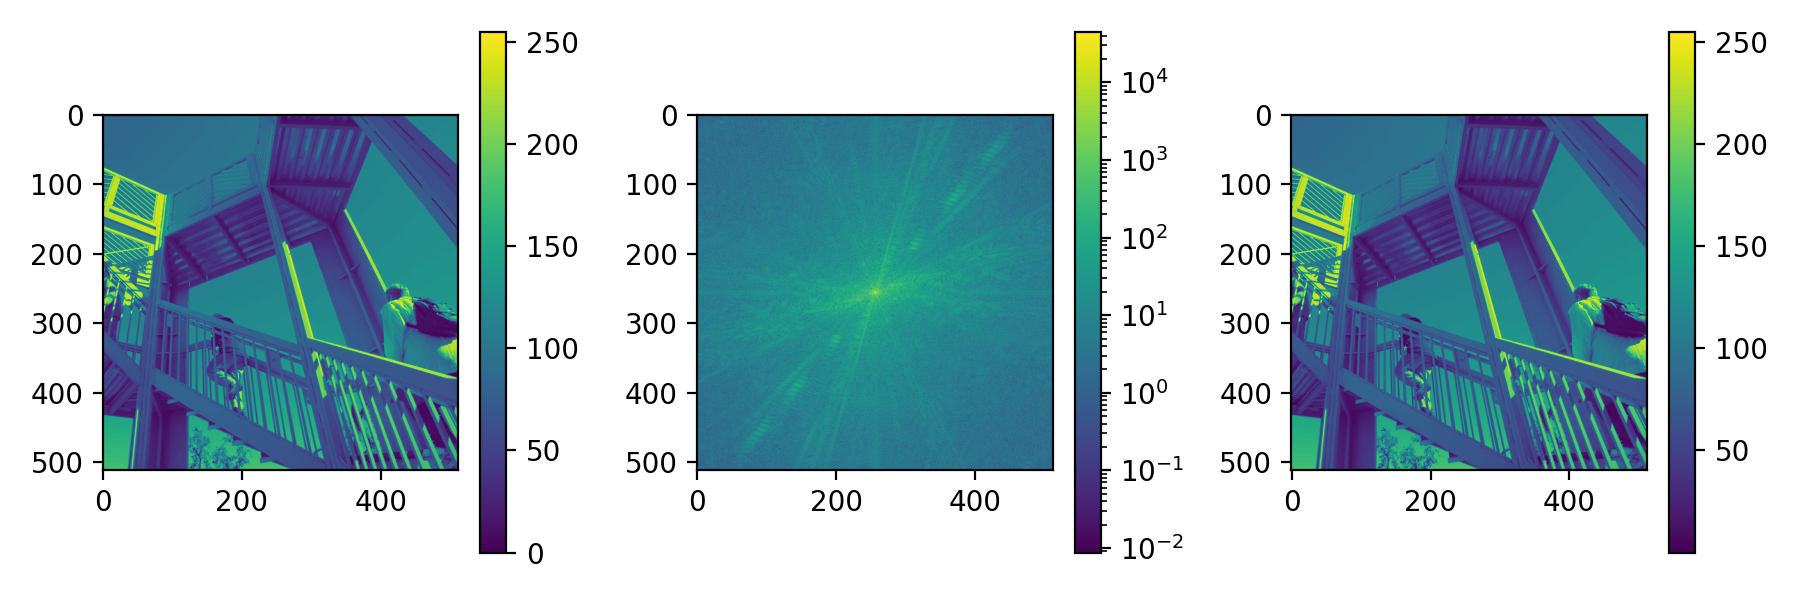

R2C transform, out-of-place in auto-allocated array


<IPython.core.display.Javascript object>


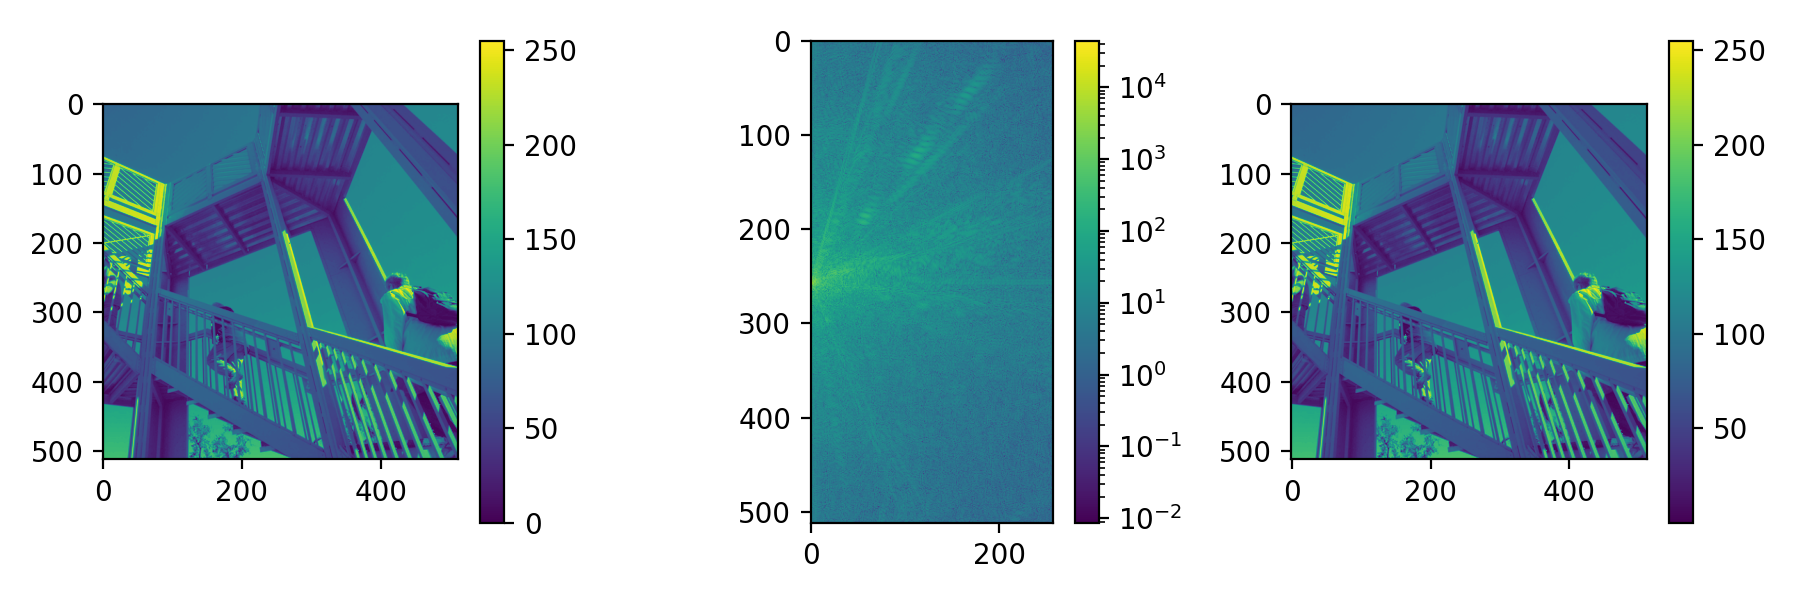

R2C transform, out-of-place


<IPython.core.display.Javascript object>


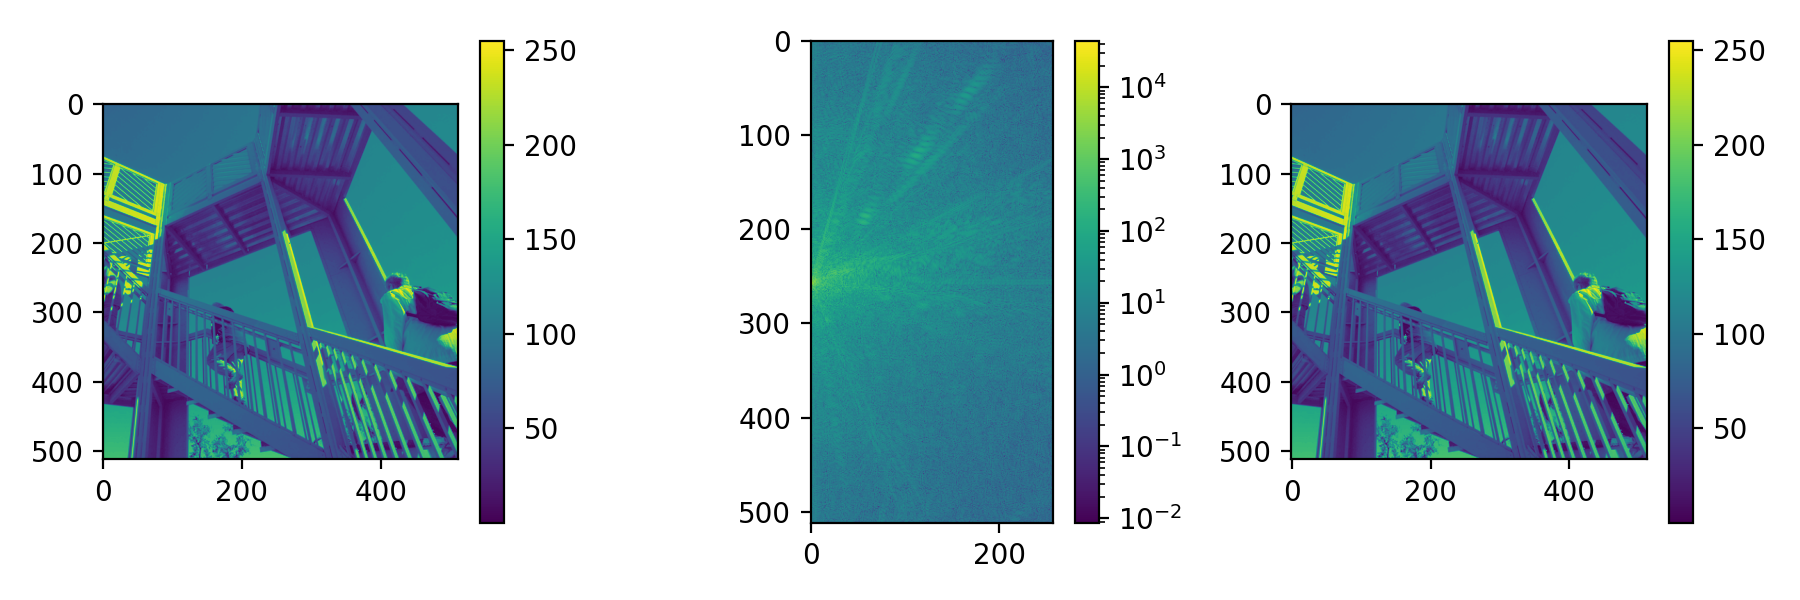

R2C transform, inplace


<IPython.core.display.Javascript object>


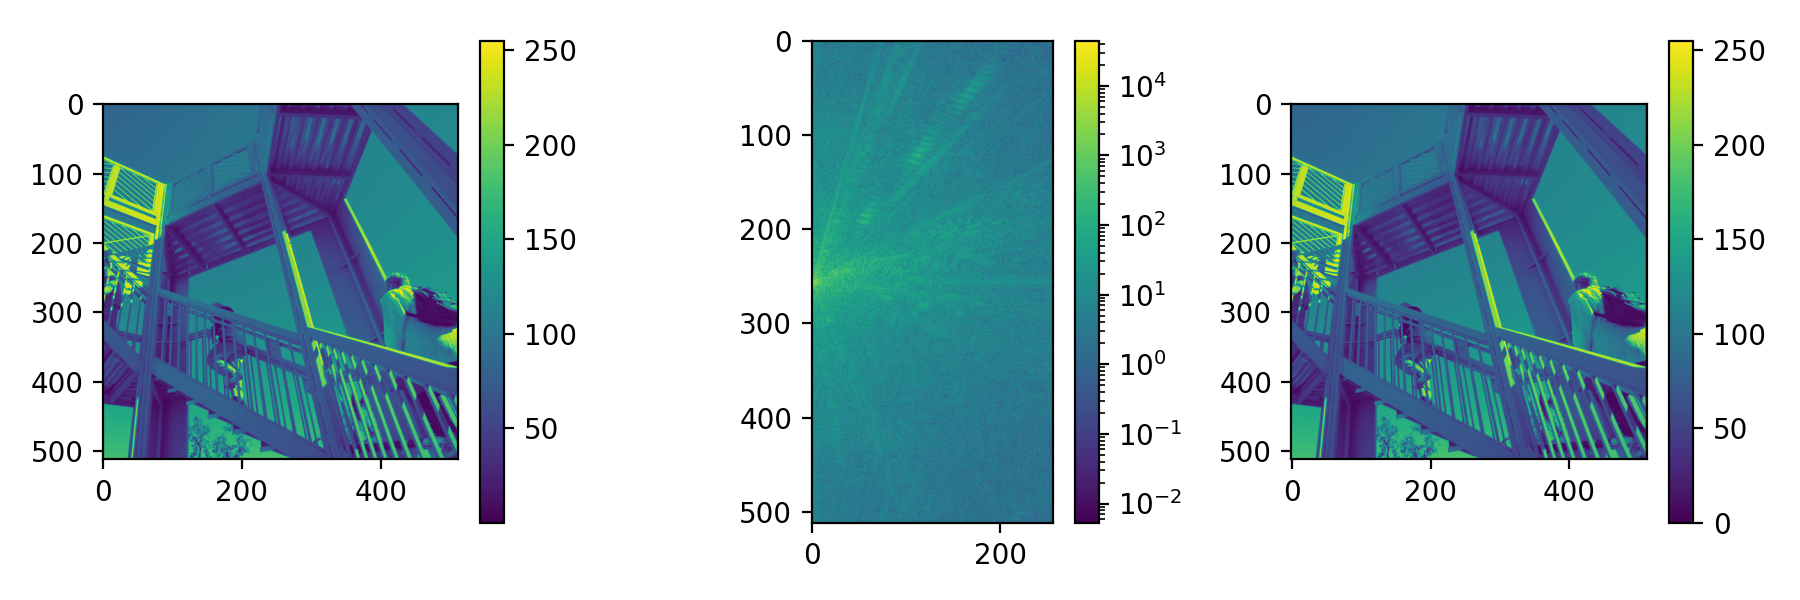

In [5]:
try:
    import pycuda.autoinit
    import pycuda.gpuarray as cua
    has_pycuda = True
except:
    has_pycuda = False

if has_pycuda:
    print("C2C transform")
    d = cua.to_gpu(ascent().astype(np.complex64))
    do_fft_and_plot(d)
    
    print("R2C transform, out-of-place in auto-allocated array")
    d = cua.to_gpu(ascent().astype(np.float32))
    do_rfft_and_plot(d)
    
    print("R2C transform, out-of-place")
    dr = cua.to_gpu(ascent().astype(np.float32))
    sh = (dr.shape[0], dr.shape[1]//2+1)
    dc = cua.empty(sh, dtype=np.complex64)
    do_rfft_and_plot(dr, dc)

    print("R2C transform, inplace")
    dr = cua.to_gpu(ascent().astype(np.float32))
    do_rfft_and_plot(dr, dr)
else:
    print("PyCUDA is not available")

## CuPy

C2C transform


<IPython.core.display.Javascript object>


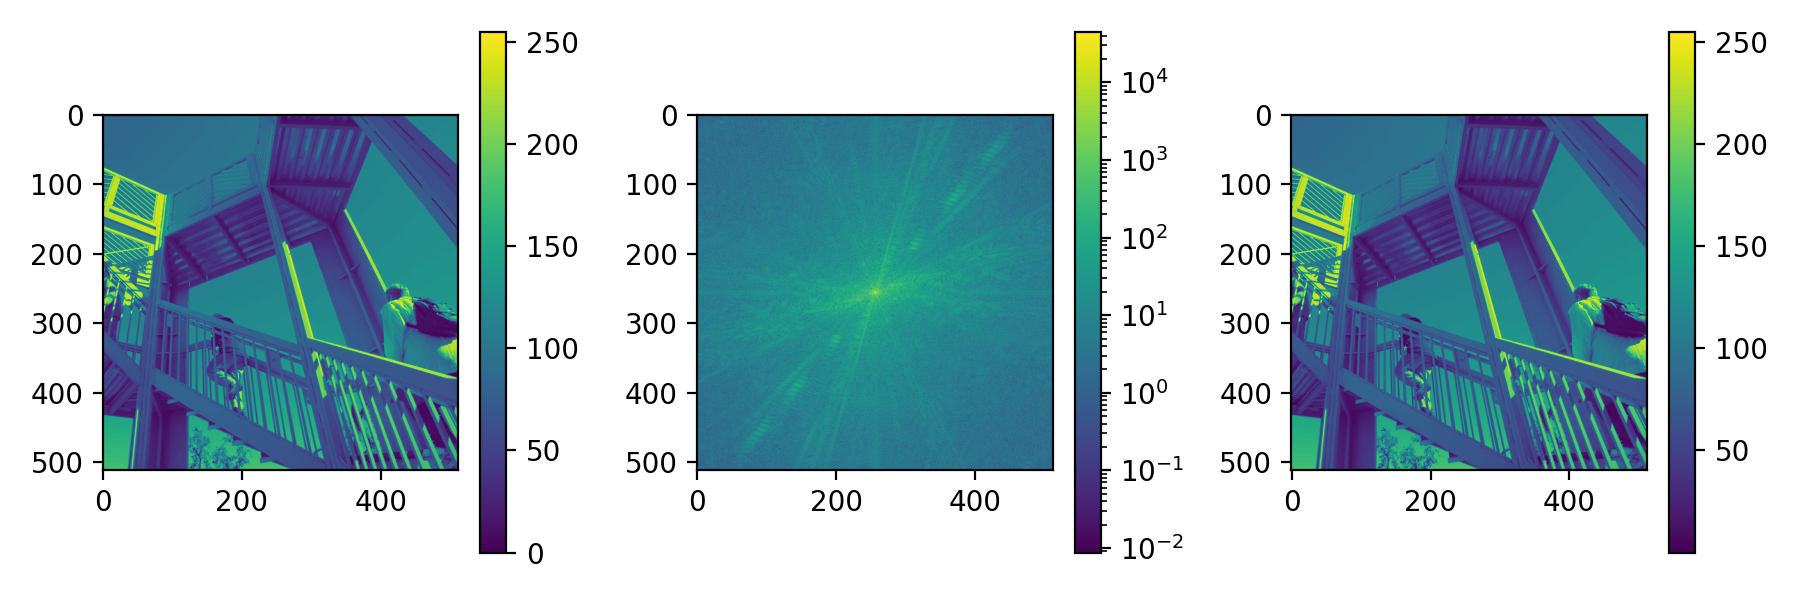

R2C transform, out-of-place in auto-allocated array


<IPython.core.display.Javascript object>


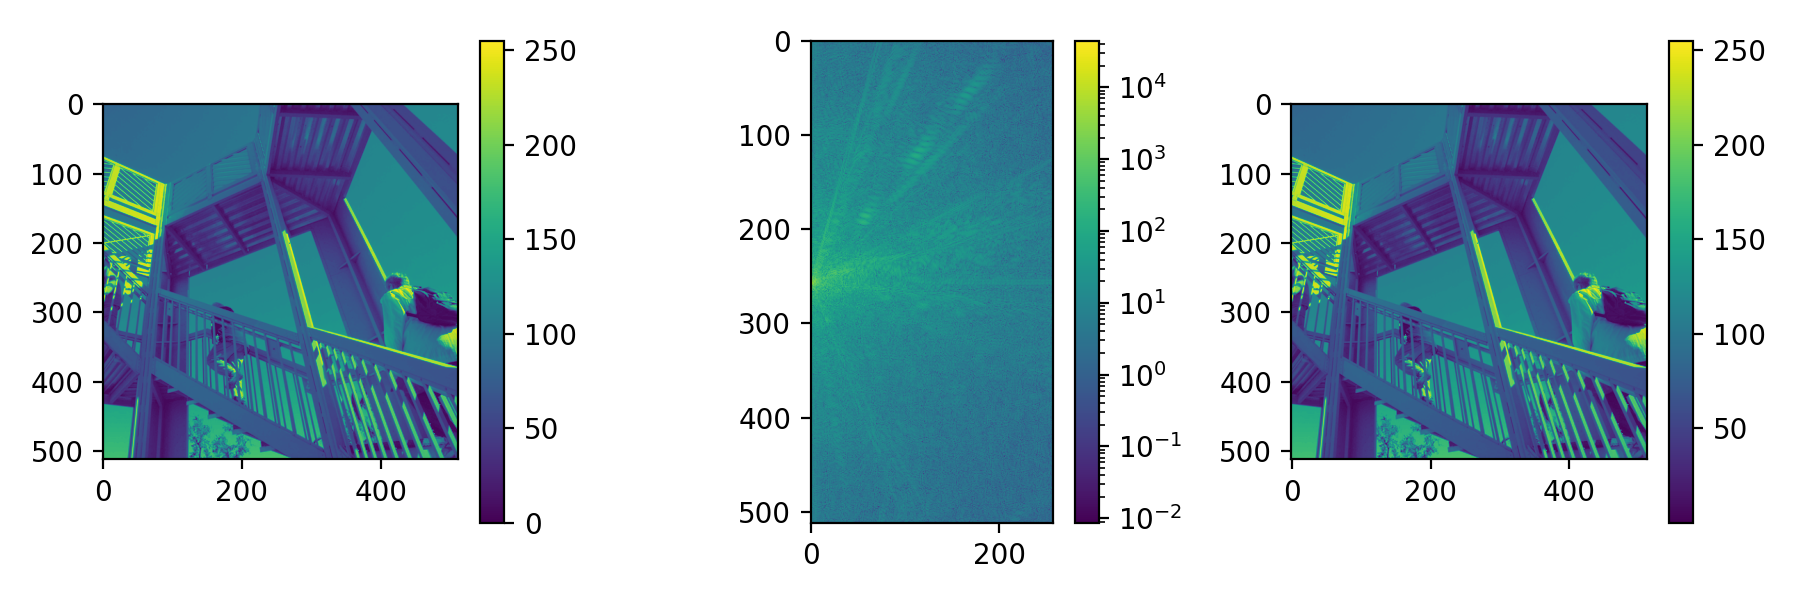

R2C transform, out-of-place


<IPython.core.display.Javascript object>


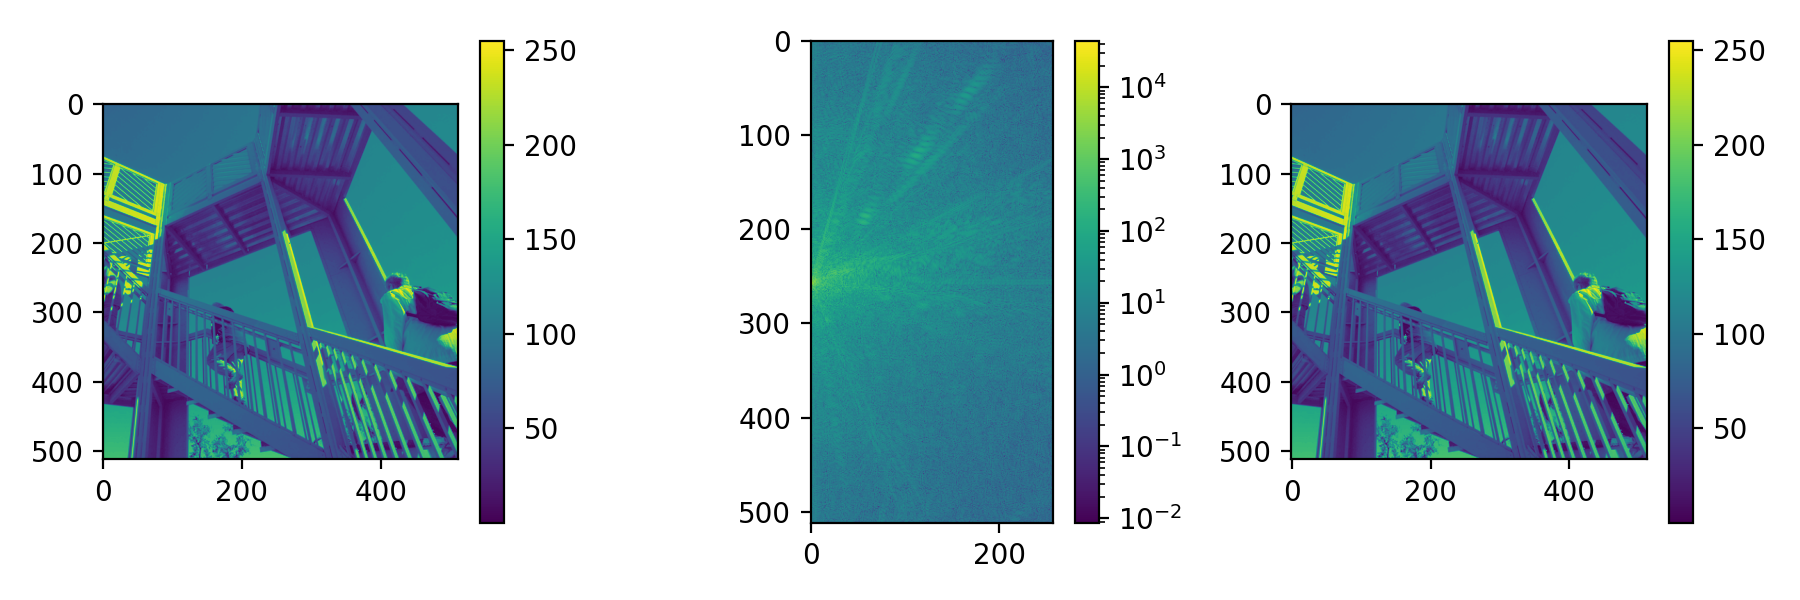

R2C transform, inplace


<IPython.core.display.Javascript object>


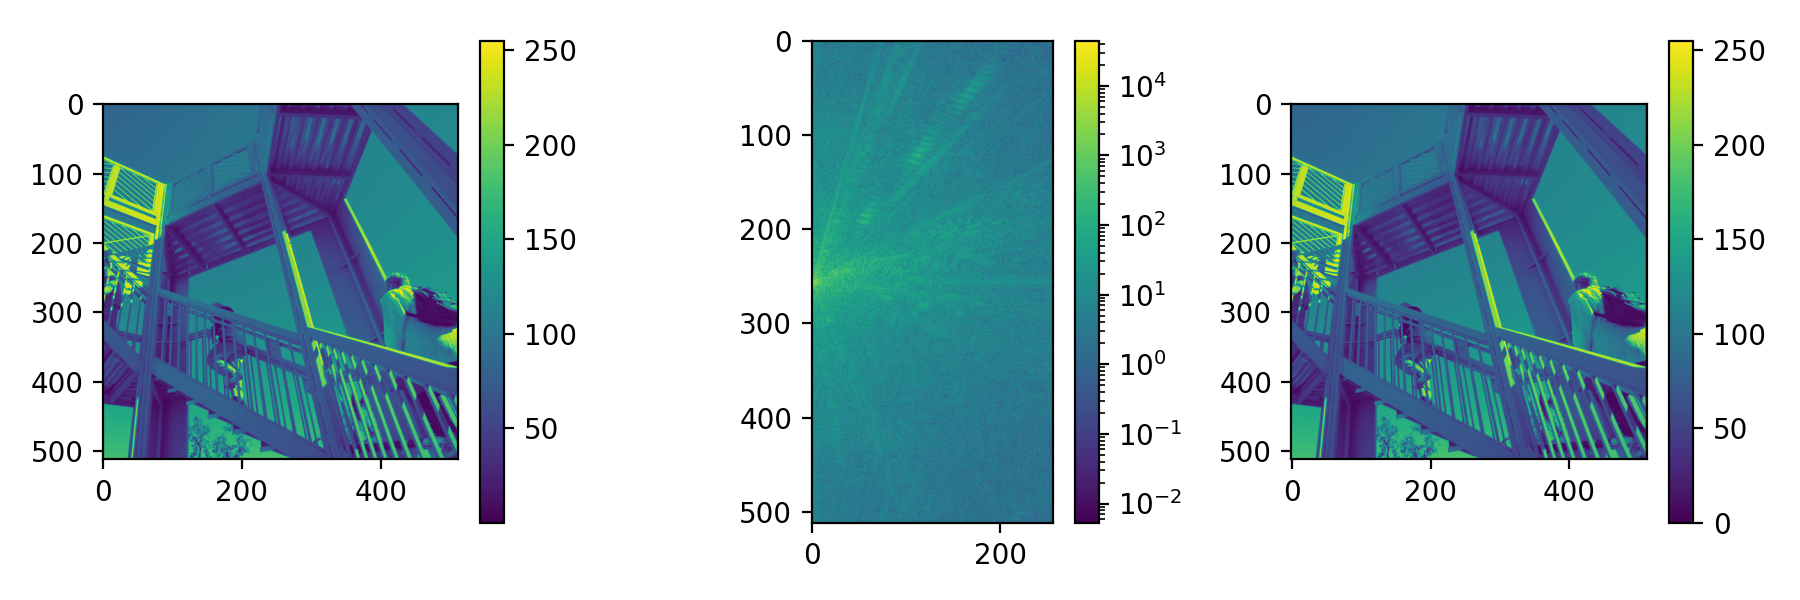

In [6]:
try:
    import cupy as cp
    has_cupy = True
except:
    has_cupy = False

if has_cupy:
    print("C2C transform")
    d = cp.array(ascent().astype(np.complex64))
    do_fft_and_plot(d)
    
    print("R2C transform, out-of-place in auto-allocated array")
    d = cp.array(ascent().astype(np.float32))
    do_rfft_and_plot(d)
    
    print("R2C transform, out-of-place")
    dr = cp.array(ascent().astype(np.float32))
    sh = (dr.shape[0], dr.shape[1]//2+1)
    dc = cp.empty(sh, dtype=np.complex64)
    do_rfft_and_plot(dr, dc)

    print("R2C transform, inplace")
    dr = cp.array(ascent().astype(np.float32))
    do_rfft_and_plot(dr, dr)
else:
    print("CuPy is not available")

## PyOpenCL

Selected device:  NVIDIA A40
C2C transform


<IPython.core.display.Javascript object>


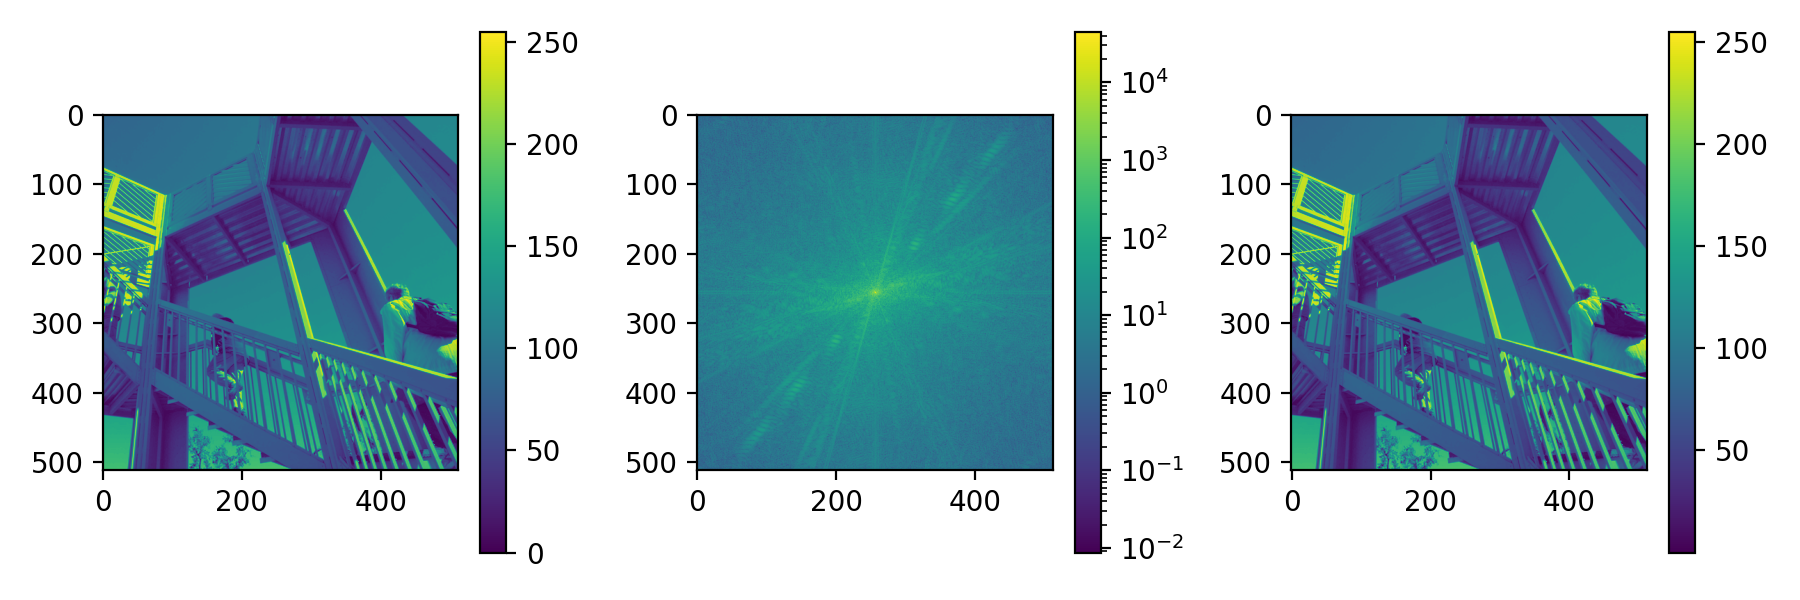

R2C transform, out-of-place in auto-allocated array


<IPython.core.display.Javascript object>


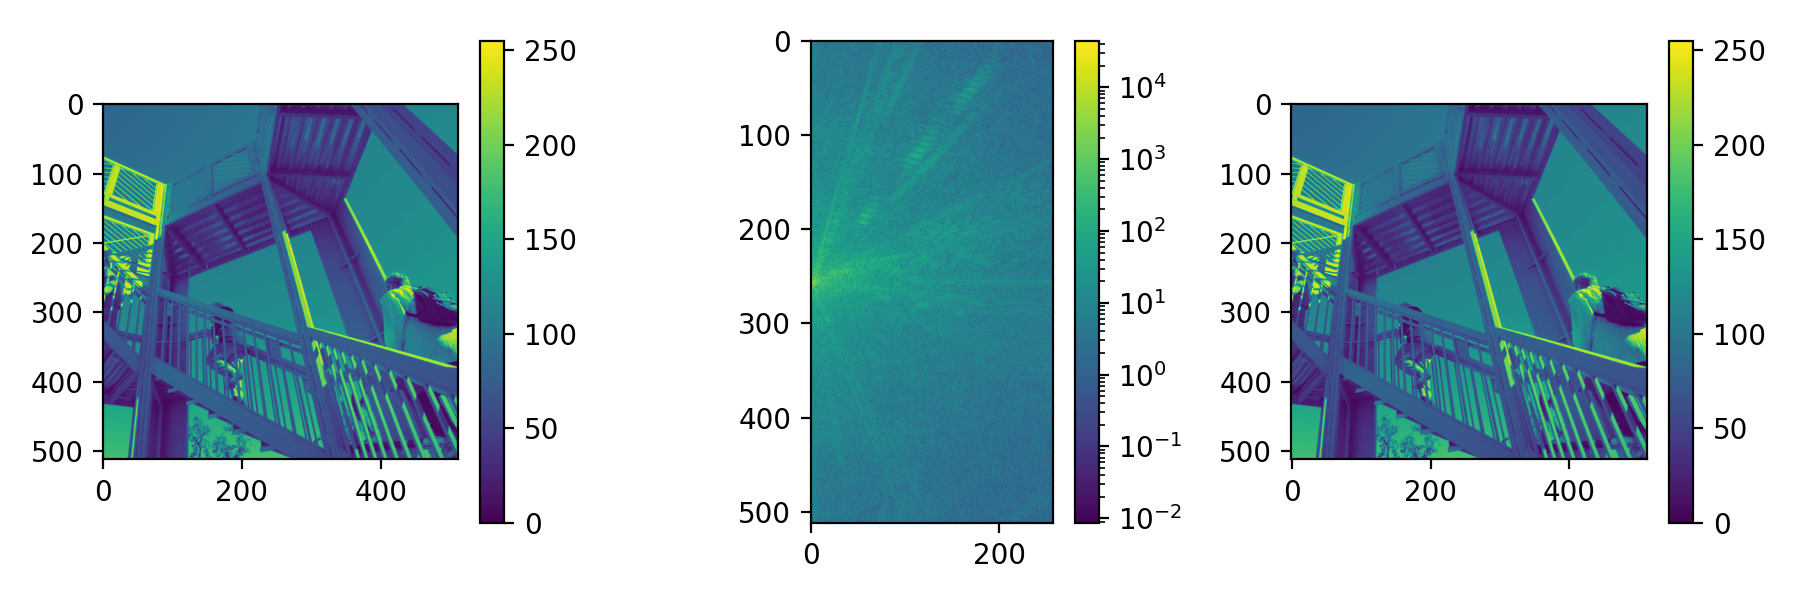

R2C transform, out-of-place


<IPython.core.display.Javascript object>


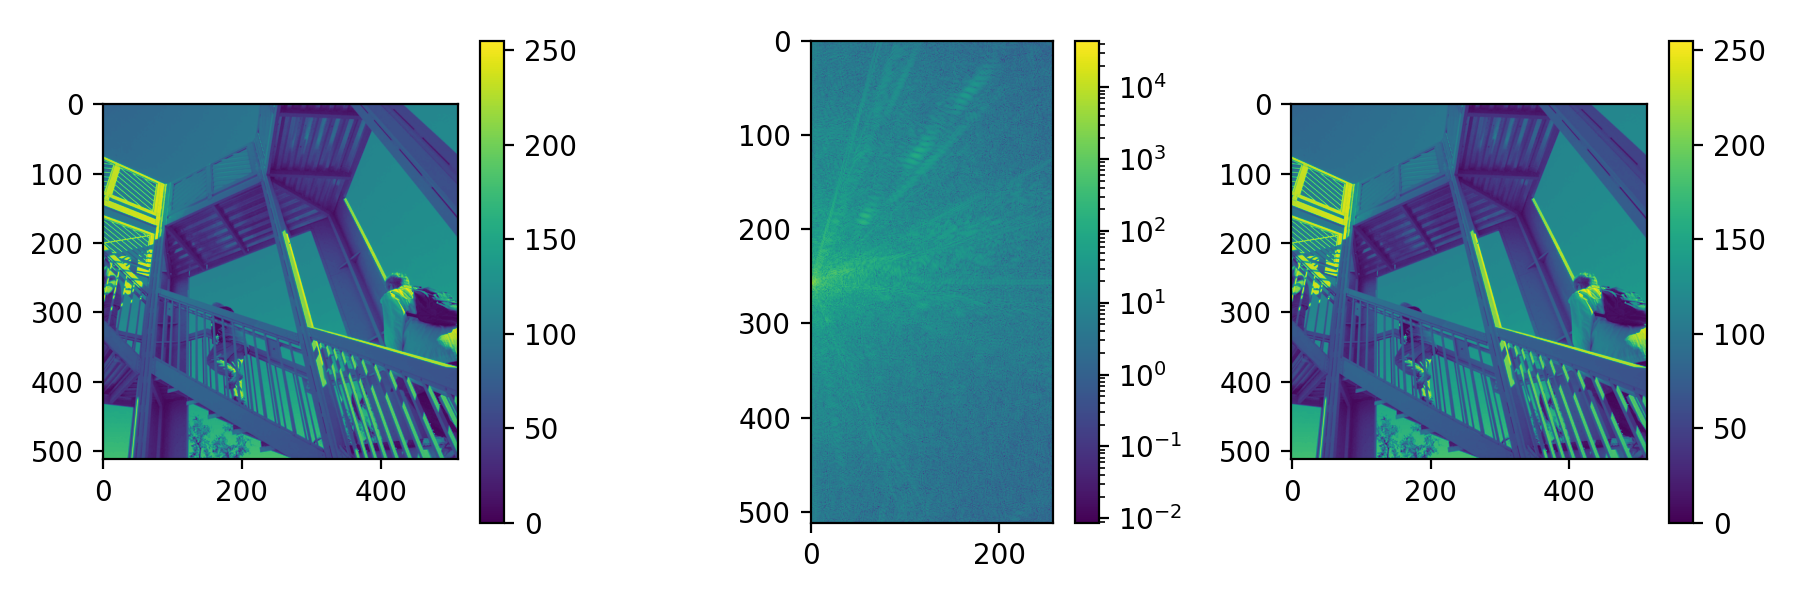

R2C transform, inplace


<IPython.core.display.Javascript object>


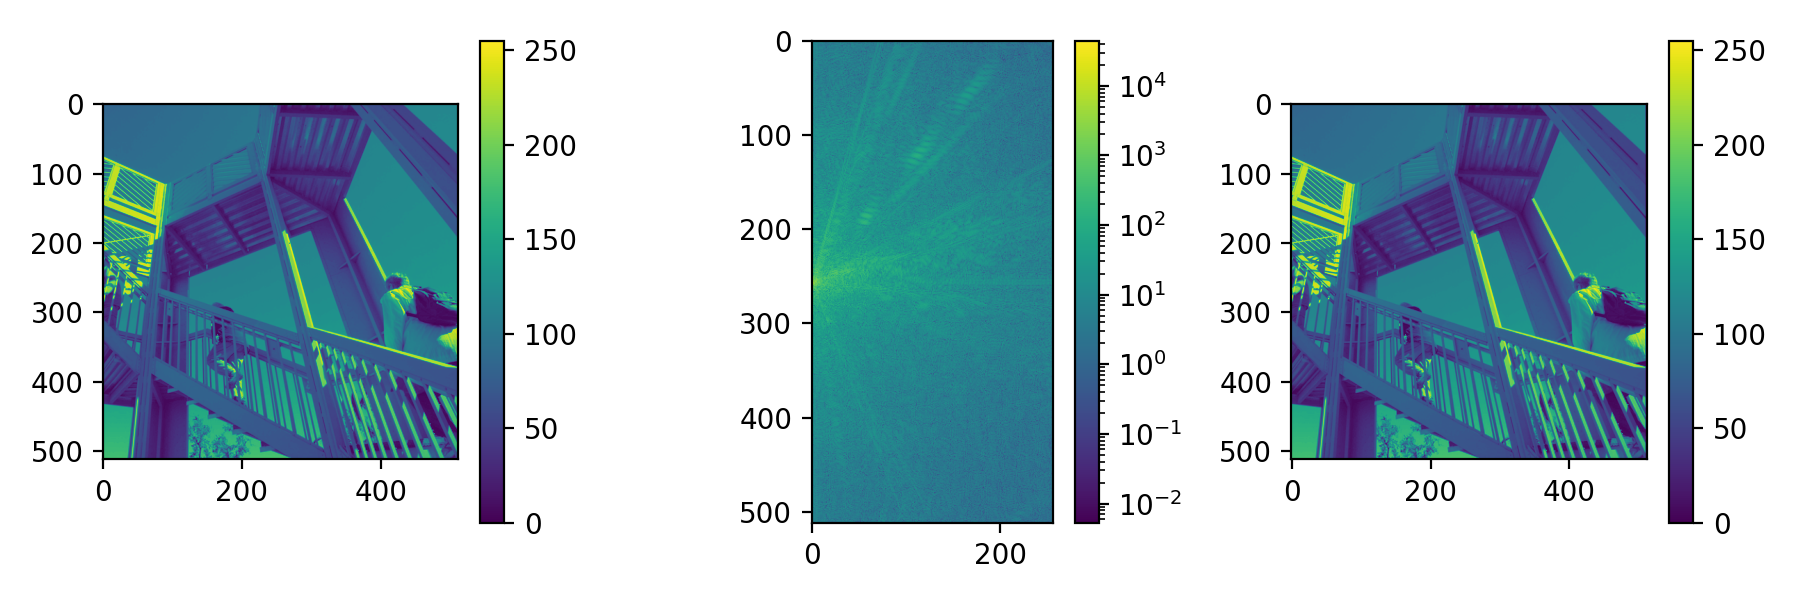

In [8]:
try:
    import pyopencl as cl
    import pyopencl.array as cla
    import os
    
    # Create some context on the first available GPU
    if 'PYOPENCL_CTX' in os.environ:
        ctx = cl.create_some_context()
    else:
        ctx = None
        # Find the first OpenCL GPU available and use it, unless
        for p in cl.get_platforms():
            for d in p.get_devices():
                if d.type & cl.device_type.GPU == 0:
                    continue
                print("Selected device: ", d.name)
                ctx = cl.Context(devices=(d,))
                break
            if ctx is not None:
                break
    cq = cl.CommandQueue(ctx)

    has_pyopencl = True
except:
    has_pyopencl = False

if has_pyopencl:
    print("C2C transform")
    d = cla.to_device(cq, ascent().astype(np.complex64))
    do_fft_and_plot(d)
    
    print("R2C transform, out-of-place in auto-allocated array")
    d = cla.to_device(cq, ascent().astype(np.float32))
    do_rfft_and_plot(d)
    
    print("R2C transform, out-of-place")
    dr = cla.to_device(cq, ascent().astype(np.float32))
    sh = (dr.shape[0], dr.shape[1]//2+1)
    dc = cla.empty(cq, sh, dtype=np.complex64)
    do_rfft_and_plot(dr, dc)
    
    print("R2C transform, inplace")
    dr = cla.to_device(cq, ascent().astype(np.float32))
    do_rfft_and_plot(dr, dr)
else:
    print("PyOpenCL is not available")